In [34]:
import os
import sys
import traceback
import re
import enum
import json
import tzlocal
from datetime import datetime, timedelta, timezone
import logging
import uuid
import arrow
from typing import Dict, List, Tuple, Any
import pandas as pd
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm # in-compatible with pypy
from hurst import compute_Hc # compatible with pypy
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import time

In [ ]:
trade_file = 'orderhist_cache.csv'
export_file = f"{trade_file.replace('.csv','')}.flattenned.csv"

ACC_INITIAL_EQUITY : float = 100

pd_orderhist = pd.read_csv(trade_file)
pd_orderhist.sort_values(by=['timestamp_ms'], ascending=[True])
pd_orderhist['entry_datetime'] = pd_orderhist['datetime'].shift(1)
pd_orderhist['entry_timestamp_ms'] = pd_orderhist['timestamp_ms'].shift(1)
pd_orderhist['entry_datetime'] = pd.to_datetime(pd_orderhist['entry_datetime'])
pd_orderhist['datetime'] = pd.to_datetime(pd_orderhist['datetime'])
pd_orderhist['amount'] = pd_orderhist['amount'].shift(1)
pd_orderhist['entry_side'] = pd_orderhist['side'].shift(1)
pd_orderhist['entry_px'] = pd_orderhist['avg_price'].shift(1)
pd_orderhist['entry_fees'] = pd_orderhist['fees'].shift(1)
pd_orderhist['total_fees'] = pd_orderhist['entry_fees'] + pd_orderhist['fees']
pd_orderhist = pd_orderhist[pd_orderhist.reason!='entry']
pd_orderhist['pnl_less_comm'] = pd_orderhist['pnl'] - pd_orderhist['total_fees']
pd_orderhist['pnl_bps'] = round(pd_orderhist['pnl_bps'], 3)
pd_orderhist['pnl_bps_less_comm'] = round(pd_orderhist['pnl_less_comm'] / pd_orderhist['amount'] * 10000, 3)
pd_orderhist['max_pain_bps'] = round(pd_orderhist['max_pain'] / pd_orderhist['amount'] * 10000, 3)
pd_orderhist['duration_hr'] = (pd_orderhist['timestamp_ms'] - pd_orderhist['entry_timestamp_ms'])/(1000*60*60)
pd_orderhist['cumulative_pnl'] = pd_orderhist['pnl_less_comm'].cumsum()
pd_orderhist['total_equity'] = pd_orderhist['cumulative_pnl'] + ACC_INITIAL_EQUITY
pd_orderhist['interval_return'] = np.log(pd_orderhist['total_equity'] / pd_orderhist['total_equity'].shift(1))

pd_orderhist.rename(columns={ 'datetime' : 'exit_datetime', 'timestamp_ms' : 'exit_timestamp_ms', 'avg_price': 'exit_px', 'side' : 'exit_side', 'fees' : 'exit_fees' }, inplace=True)
columns = [ 'exit_datetime', 'exit_timestamp_ms', 'entry_datetime', 'entry_timestamp_ms', 'ticker', 'entry_side', 'amount', 'entry_px', 'exit_px', 'reason', 'reason2', 'pnl', 'pnl_bps', 'pnl_less_comm', 'pnl_bps_less_comm', 'max_pain', 'max_pain_bps', 'entry_fees', 'exit_fees', 'total_fees', 'duration_hr', 'cumulative_pnl', 'total_equity', 'interval_return', 'remarks']
pd_orderhist = pd_orderhist[columns]


pd_orderhist.set_index('exit_datetime', inplace=True)

pd_orderhist.drop(pd_orderhist.columns[pd_orderhist.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
pd_orderhist.drop(pd_orderhist.columns[pd_orderhist.columns.str.contains('entry_timestamp_ms',case = False)],axis = 1, inplace = True)
pd_orderhist.drop(pd_orderhist.columns[pd_orderhist.columns.str.contains('exit_timestamp_ms',case = False)],axis = 1, inplace = True)
pd_orderhist.drop(pd_orderhist.columns[pd_orderhist.columns.str.contains('exchange',case = False)],axis = 1, inplace = True)

pd_orderhist

,entry_datetime,ticker,entry_side,amount,entry_px,exit_px,reason,reason2,pnl,pnl_bps,...,max_pain,max_pain_bps,entry_fees,exit_fees,total_fees,duration_hr,cumulative_pnl,total_equity,interval_return,remarks
exit_datetime,,,,,,,,,,,,,,,,,,,,,
2026-01-26 17:51:03.012786,2026-01-26 17:30:29.952726,SOL/USDT:USDT,sell,123.28,123.28,123.98,SL,NaN,-0.70,-56.486,...,0.00,0.000,0.049312,0.049592,0.098904,0.342517,-0.798904,99.201096,NaN,NaN
2026-01-26 21:42:38.989019,2026-01-26 21:40:43.643535,SOL/USDT:USDT,buy,124.12,124.12,124.58,CLOSED,NaN,0.46,36.908,...,-0.23,-18.530,0.049648,0.049832,0.099480,0.032041,-0.438384,99.561616,0.003628,NaN
2026-01-27 00:06:00.962597,2026-01-26 21:45:29.516053,SOL/USDT:USDT,buy,124.58,124.58,123.95,SL,NaN,-0.63,-50.825,...,-0.56,-44.951,0.049832,0.049580,0.099412,2.342068,-1.167796,98.832204,-0.007353,NaN
2026-01-27 02:46:14.253443,2026-01-27 01:45:37.069094,SOL/USDT:USDT,buy,124.33,124.33,124.88,CLOSED,NaN,0.55,44.041,...,-0.21,-16.891,0.049732,0.049952,0.099684,1.010329,-0.717480,99.282520,0.004546,NaN
2026-01-27 09:16:05.527903,2026-01-27 05:20:31.104629,SOL/USDT:USDT,sell,124.17,124.17,123.64,CLOSED,NaN,0.53,42.882,...,-0.55,-44.294,0.049668,0.049456,0.099124,3.926229,-0.286604,99.713396,0.004331,NaN
2026-01-27 13:30:39.181104,2026-01-27 12:47:38.913218,SOL/USDT:USDT,sell,123.81,123.81,123.20,CLOSED,NaN,0.61,49.531,...,-0.47,-37.961,0.049524,0.049280,0.098804,0.716741,0.224592,100.224592,0.005114,NaN
2026-01-27 14:38:07.734289,2026-01-27 14:32:50.708016,SOL/USDT:USDT,buy,124.14,124.14,123.45,SL,NaN,-0.69,-55.895,...,-0.51,-41.083,0.049656,0.049380,0.099036,0.088063,-0.564444,99.435556,-0.007904,NaN
2026-01-27 16:10:44.003780,2026-01-27 16:06:59.631154,SOL/USDT:USDT,buy,125.79,125.79,126.18,CLOSED,NaN,0.39,30.905,...,-0.88,-69.958,0.050316,0.050472,0.100788,0.062326,-0.275232,99.724768,0.002904,NaN
2026-01-27 17:37:32.027308,2026-01-27 17:32:38.109124,SOL/USDT:USDT,sell,124.39,124.39,124.07,CLOSED,NaN,0.32,25.801,...,0.00,0.000,0.049756,0.049628,0.099384,0.081644,-0.054616,99.945384,0.002210,NaN


In [39]:
pd_orderhist.to_csv(export_file)

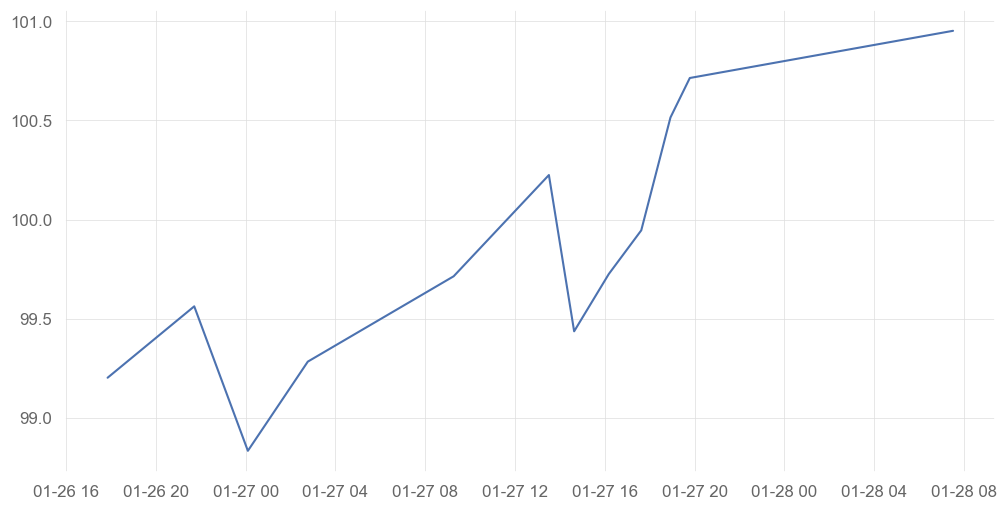

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(pd_orderhist.index, pd_orderhist['total_equity'], label='Total Equity')

                     Strategy
-------------------  ----------
Start Period         2026-01-26
End Period           2026-01-28
Risk-Free Rate       3.5%
Time in Market       100.0%

Cumulative Return    1.75%
CAGR﹪               48.9%

Sharpe               4.9
Prob. Sharpe Ratio   77.78%
Sortino              6.97
Sortino/√2           4.93
Omega                2.03

Max Drawdown         -0.79%
Max DD Date          2026-01-27
Max DD Period Start  2026-01-27
Max DD Period End    2026-01-27
Longest DD Days      1

Gain/Pain Ratio      -
Gain/Pain (1M)       -

Payoff Ratio         0.48
Profit Factor        2.15
Common Sense Ratio   1.52
CPC Index            0.84
Tail Ratio           0.71
Outlier Win Ratio    1.55
Outlier Loss Ratio   1.03

MTD                  1.75%
3M                   1.75%
6M                   1.75%
YTD                  1.75%
1Y                   1.75%
3Y (ann.)            48.9%
5Y (ann.)            48.9%
10Y (ann.)           48.9%
All-time (ann.)      48.9%

Avg. Drawdo

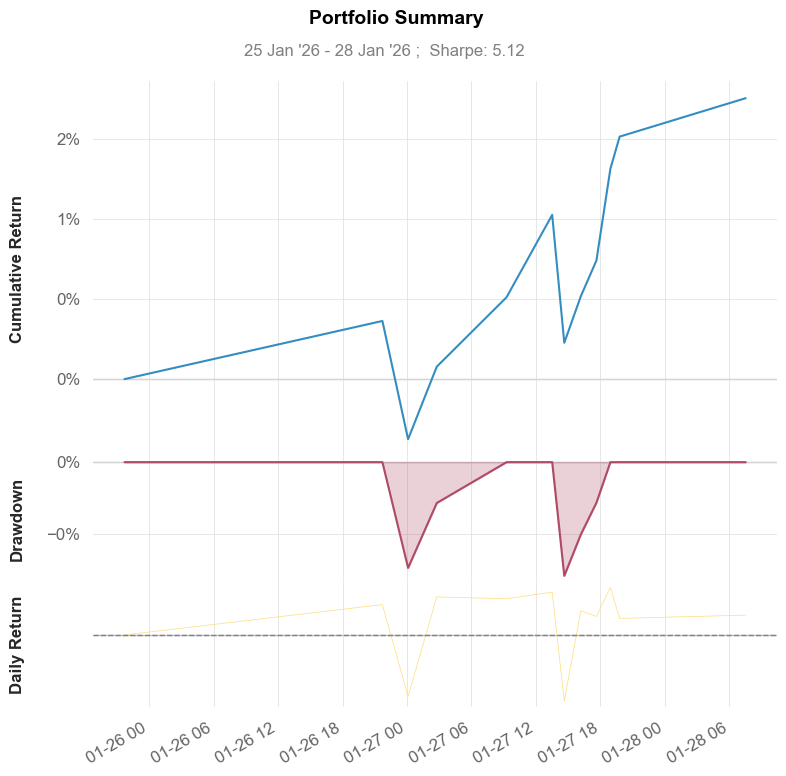

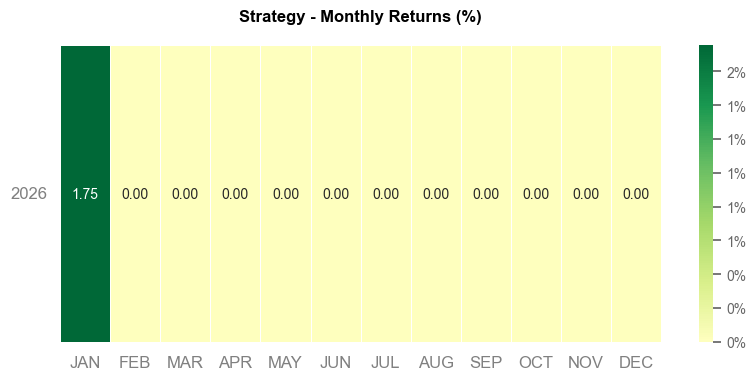

In [41]:
# https://github.com/ranaroussi/quantstats
%matplotlib inline
import quantstats as qs

RISK_FREE_RATE = 0.035

qs.reports.basic(
    returns=pd_orderhist['interval_return'], 
    rf=RISK_FREE_RATE,
    title="Tear Sheet"
    )